<a href="https://colab.research.google.com/github/maureenwidjaja/HW0/blob/main/keras_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixed Data Features

- data comes in multiple 'modes' or formats

some e.g
- picutres (images) and captions (text)
- descriptions (text) and timestamps (numbers).
- diagnosis - medical diagnosis, vitals (numbers), xray(rumbers)


We used a single pipeline that we built for the data we needed to work, ususally with `keras.models.Sequential()` model.

This worked fine for those situations, but what happens when we have *multiple* complex data components that we would like to use in our models?

For example:
1. Pictures (images) and captions (text).
2. Descriptions (text) and timestamps (numbers).
3. Article bodies (text) and titles (different text).

Of course, it's possible to come up with various ad hoc ways to smoosh pieces of data together, but this isn't usually the right approach. A better thing to do is to create a more flexible model that accepts and appropriately processes different kinds of inputs. In this lecture, we'll learn how to do this.

### Key Tools

- Labeled data sets.
- The Keras functional API (alternative to Sequential API).

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from keras import layers
from keras import losses
import keras

from keras.layers import TextVectorization

from sklearn.preprocessing import LabelEncoder

# for embedding viz
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

Our data set for this lecture contains various information about various musical tracks produced between the years 1950 and 2019. You can find it on Kaggle [here](https://www.kaggle.com/saurabhshahane/music-dataset-1950-to-2019). The data was originally published in the following data publication:

> Moura, Luan; Fontelles, Emanuel; Sampaio, Vinicius; França, Mardônio (2020), “Music Dataset: Lyrics and Metadata from 1950 to 2019”, Mendeley Data, V3, doi: 10.17632/3t9vbwxgr5.3

In [4]:
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)

Let's take a quick look:

In [5]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


We have a number of columns here! We'll focus on a few subsets in particular:

The `genre` describes the overall genre of the track. It has seven values:

In [6]:
df.groupby("genre").size()

,0
genre,
blues,4604
country,5445
hip hop,904
jazz,3845
pop,7042
reggae,2498
rock,4034


There data also includes
- The complete `lyrics` of the track (if it has any)
- The normalized `age` of the track (1.0 corresponds to tracks released in 1950, 0.0 corresponds to more recent tracks)
- A selection of columns that give the track numerical scores reflecting various attributes and topics, such as "danceability," "loudness," and "acousticness."

There are also other columns in the data, but these are the ones we're going to focus on for this analysis. We are going to subset things a bit: let's focus on only a few genres, and on only relatively recent tracks.

In [7]:
df = df[df["release_date"] > 2000]
genres = ["blues", "hip hop", "country"]
df = df[df["genre"].apply(lambda x: x in genres)]

In [8]:
df.groupby("genre").size()

,0
genre,
blues,1634
country,1308
hip hop,861


In [9]:
df.shape

(3803, 31)

Mau

In [10]:
df.sample(frac=1).head() # frac will randomly shuffle data and sample a certain % of it (here is 100%)

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
11877,36508,josh thompson,comin' around,2011,country,like nail chalkboard daddy play kinda music as...,79,0.000907,0.000907,0.097054,...,0.000907,0.000907,0.427055,0.779863,0.126505,0.000000,0.355936,0.747740,obscene,0.128571
12155,37958,tim mcgraw,here tonight,2015,country,ramblin boot string loose afraid takin flight ...,90,0.000863,0.000863,0.057125,...,0.045822,0.000863,0.499621,0.754121,0.002027,0.001964,0.266282,0.726718,night/time,0.071429
12350,39002,jameson rodgers,missing one,2018,country,eagle record center console stack split desper...,88,0.000666,0.086873,0.000666,...,0.069871,0.328009,0.576519,0.795785,0.111445,0.000018,0.295136,0.689680,feelings,0.028571
28194,82187,shawnna,gettin' some,2018,hip hop,gettin gettin gettin gettin head gettin gettin...,85,0.000877,0.122435,0.000877,...,0.000877,0.000877,0.826709,0.759249,0.090461,0.000000,0.605317,0.586574,obscene,0.028571
11883,36542,granger smith,i'm wearing black,2011,country,march wearin green dead come tonight wear blac...,82,0.000877,0.437766,0.000877,...,0.055178,0.000877,0.523448,0.775043,0.125501,0.000000,0.320899,0.935934,violence,0.128571


Next, let's do a categorical encoding of the `genre` column.

In [13]:
le = LabelEncoder() # change to num 1/0
df["genre_encoded"] = le.fit_transform(df["genre"])
num_genres = len(df["genre"].unique())

In [12]:
le.classes_

array(['blues', 'country', 'hip hop'], dtype=object)

In [14]:
num_genres

3

## Create a Dataset

We're now ready to create a TensorFlow `Dataset`. This is going to be a little more involved than last time, because we need to distinguish between different kinds of model inputs.

Here's a list of all the scalar "score" columns in the data frame.

In [15]:
scalars = ['dating',
           'violence',
           'world/life',
           'night/time',
           'shake the audience',
           'family/gospel',
           'romantic',
           'communication',
           'obscene',
           'music',
           'movement/places',
           'light/visual perceptions',
           'family/spiritual',
           'like/girls',
           'sadness',
           'feelings',
           'danceability',
           'loudness',
           'acousticness',
           'instrumentalness',
           'valence',
           'energy']

Because we have multiple inputs, we are going to construct our `Dataset` from a tuple of dictionaries. The first dictionary is going to specify the different components in the predictor data, while the second dictionary is going to specify the different components of the target data.

In [16]:
data = tf.data.Dataset.from_tensor_slices(
    ( # give a tuple
        {
            "lyrics" : df[["lyrics"]],
            "scalars" : df[scalars]
        },
         (
             df[["genre_encoded"]]
         )
    )
)

Next, we are going to perform a train/test/validation split. For each of the three split `Datasets`, we are going to *batch* them into small chunks of data. This helps with training runtime later.

In [18]:
data = data.shuffle(buffer_size = len(data), reshuffle_each_iteration=False)

train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

# batch them into chunks - total length here is divided into groups of 20
train = data.take(train_size).batch(20)
val   = data.skip(train_size).take(val_size).batch(20)
test  = data.skip(train_size + val_size).batch(20)

len(train), len(val), len(test)

(134, 19, 39)

Each of the numbers above should be multipled by the batch size to give the total number of rows in each `Dataset`.

The code below sets up exactly the same text preprocessing that we did [last lecture](https://colab.research.google.com/drive/1xDee6vdivmS8pLDQp7gtAnoKfANwN3Cu?usp=sharing).

In [19]:
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data) # make lowercase
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'') # remove punctuation
    return no_punctuation

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

vectorize_layer.adapt(train.map(lambda x, y: x["lyrics"]))

## The Keras Functional API

In previous lectures, we used the `Sequential` API for constructing models. For example, we wrote code like this:

```python
model = keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 3),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(len(categories))]
)
```

This model is designed to accept a single kind of input (in this case text) and spit out a single output. However, in our case we have two distinct *kinds* of input: the song lyrics and the scalar scores. It wouldn't really make much sense to pass the scalar scores through a text vectorization or embedding layer. For this reason, we need to move beyond the `Sequential` API and instead constructing our models using a somewhat more manual approach, referred to as the `Functional` API.

### Inputs

Start by specifying the two kinds of `keras.Input` for our model. You should have one input for each qualitatively distinct "kind" of predictor data. All the parameters here are important:

- `shape` should describe the shape of a single item of data. For example, the `lyrics` column contains just one entry for each song, so the shape is `(1,)` (a tuple of length 1). On the other hand, there are `len(scalars) = 22` distinct columns of scalar scores.
- the `name` should be some descriptive name that you're able to remember for later.
- The `dtype` specifies the kind of data contained in each of the input tensors.

In [20]:
# inputs:
# 1. lyrics
lyrics_input = keras.Input(
    shape = (1,), # shape of 1 data in tuple form
    name = "lyrics",
    dtype = "string"
)

# 2. scalars data
scalars_input = keras.Input(
    shape = (len(scalars),),
    name = "scalars",
    dtype = "float64"
)

## Hidden Layers

First, let's write a pipeline for the lyrics. This pipeline is pretty much the same as the one we used earlier for text classification -- we're just building it differently.

### WE ARE USING FUNCTIONAL API NOW (NOT SEQUENTIAL ANYMORE)

so think x ->> applied to f(x) ->>> then applied to f1(f(x)) ->> then fn(..f1(f(x)))

In [21]:
# layers for processing the lyrics, pretty much the same as from our lecture
# on text classification
lyrics_features = vectorize_layer(lyrics_input) # apply functions to all input
lyrics_features = layers.Embedding(size_vocabulary, 3, name = "embedding")(lyrics_features)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.GlobalAveragePooling1D()(lyrics_features)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.Dense(32, activation='relu')(lyrics_features) # outputs 32 num

Next, let's write a pipeline for the scalars. We don't need to do anything fancy with them, so instead of messing with `Embeddings` and the like, we're just going to pass them through a `Dense` layer.

In [24]:
scalar_features = layers.Dense(32, activation='relu')(scalars_input) # latest output feature, outputs 32 num

Here's simultaneously the most important and most boring part of the whole model: we are going to `concatenate` the output of the `lyrics` pipeline with the output of the `scalar` pipeline:

In [25]:
main = layers.concatenate([lyrics_features, scalar_features], axis = 1)

Finally, let's pass the consolidated set of computed features through a few more `Dense` layers. Remember that the very last `Dense` layer should have a number of outputs equal to the number of classes in the data.

In [26]:
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(num_genres, name = "genre")(main)

So far, we haven't actually created a model yet -- just a bunch of interrelated layers. We create the model by specifying the input(s) and output.

In [27]:
model = keras.Model(
    inputs = [lyrics_input, scalars_input],
    outputs = output
)

The model summary provides one good way to look at the structure of the model, but it can be difficult to read when there are multiple inputs:

In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lyrics (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 500)            │              0 │ lyrics[0][0]           │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 3)         │          6,000 │ text_vectorization[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 500, 3)         │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 3)              │              0 │ dropout[0][0]          │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scalars (InputLayer)      │ (None, 22)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 3)              │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 22)             │              0 │ scalars[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            128 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │            736 │ cast_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64)             │              0 │ dense[0][0],           │
│ (Concatenate)             │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre (Dense)             │ (None, 3)              │             99 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,043 (35.32 KB)

 Trainable params: 9,043 (35.32 KB)

 Non-trainable params: 0 (0.00 B)

Something a bit more visually attractive can be obtained by using the `plot_model` function:

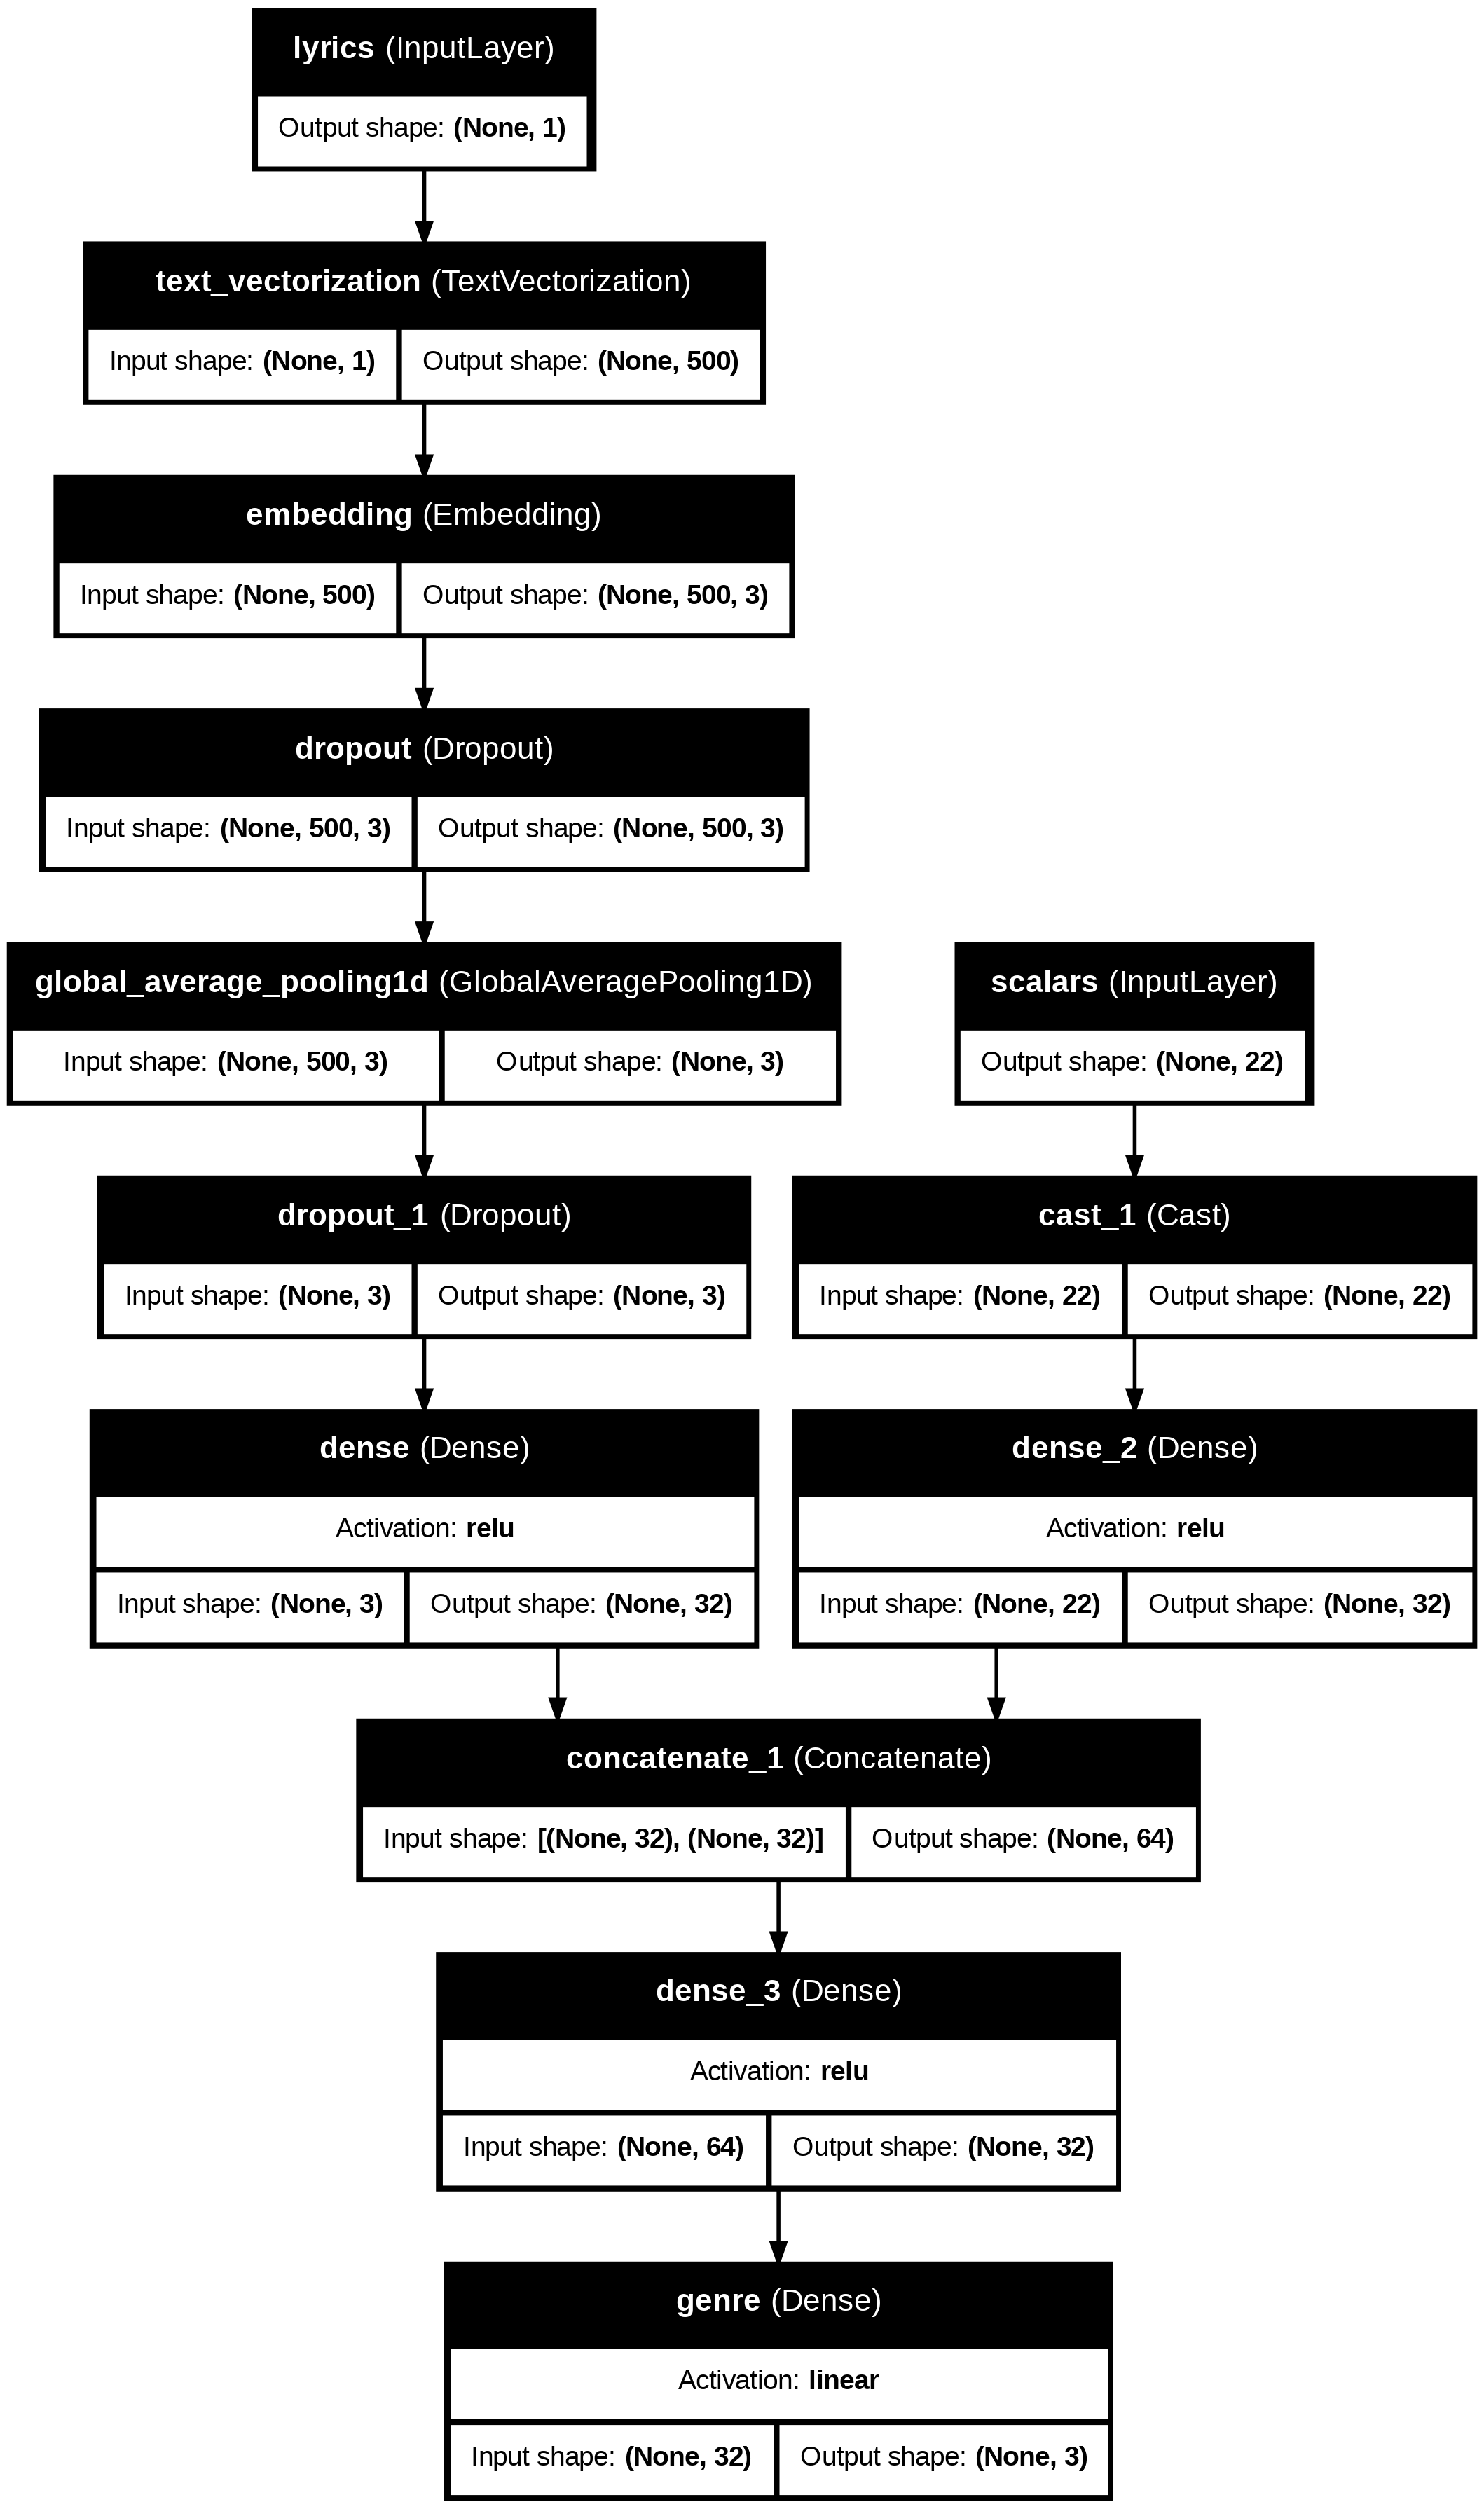

In [29]:
keras.utils.plot_model(model, "genre_classifier_model.png", show_shapes=True,
                       show_layer_names=True,
                       show_layer_activations=True)

Now we're ready to train and evaluate our model as usual! As always, we need to compile:

In [ ]:
model.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

And now we train!

We have seen that
Below is how you would perform early stopping -- a way to avoid overfitting.

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = model.fit(train,
                    validation_data=val,
                    epochs = 50,
                    callbacks=[callback],
                    verbose = True)

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4377 - loss: 1.0131 - val_accuracy: 0.5789 - val_loss: 0.8187
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6178 - loss: 0.8038 - val_accuracy: 0.6263 - val_loss: 0.7393
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6492 - loss: 0.7503 - val_accuracy: 0.6737 - val_loss: 0.6989
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6616 - loss: 0.7225 - val_accuracy: 0.6895 - val_loss: 0.6729
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6648 - loss: 0.7062 - val_accuracy: 0.7000 - val_loss: 0.6563
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6809 - loss: 0.6945 - val_accuracy: 0.7158 - val_loss: 0.6472
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6872 - loss: 0.6851 - val_accuracy: 0.7158 - val_loss: 0.6403
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6905 - loss: 0.6769 - val_accu

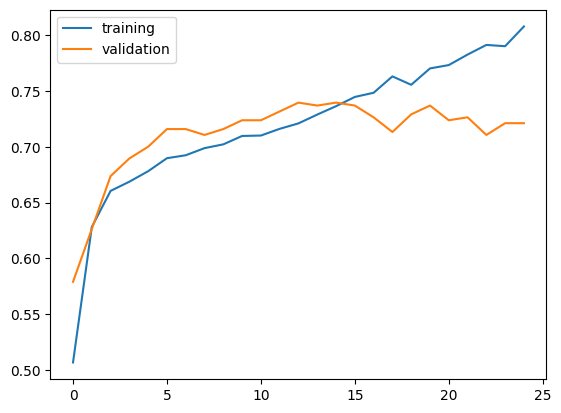

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"],label='training')
plt.plot(history.history["val_accuracy"],label='validation')
plt.legend()

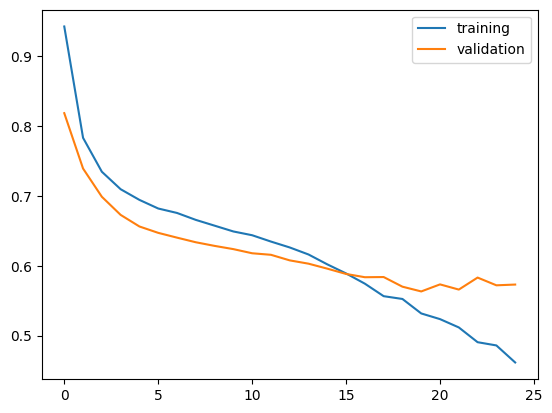

In [ ]:
plt.plot(history.history["loss"],label='training')
plt.plot(history.history["val_loss"],label='validation')
plt.legend()

In [ ]:
model.evaluate(test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7094 - loss: 0.6373


[0.630810558795929, 0.7095926403999329]

## Visualizing Embeddings

As usual, it's fun to take a look at the embedding learned by our model. Provided that we gave our embedding layer a name, the same approach as last time works just fine:

In [ ]:
weights = model.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [ ]:
import plotly.express as px
fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = list(np.ones(len(embedding_df))),
                 size_max = 5,
                 hover_name = "word")

fig.show()